# Comparision of Systematic and Random Scan Gibbs Sampling algorithms

We have seen in the previous two tutorials how to run the Gibbs samplers for both the Systematic scan and Random scan regimes. In this notebook we will compare the two approaches, both in terms of _execution time_ and _accuracy_.

In [1]:
# Import required libraries
import seqgibbs

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import time

## Execution time

We run 10 times each of the samplers for 200 steps for the same bivariate normal distribution as in the tutorials:

Let $X := (X_1,X_2) \sim N(\mu, \Sigma)$ where $\mu = (\mu_1, \mu_2)$ and covariance matrix 
$
\Sigma = \begin{pmatrix}
\sigma^2_1 & \rho \\
\rho & \sigma^2_2
\end{pmatrix}
$
.



The Gibbs sampler proceeds as follows in this case with the following conditional probabilities:

(a) Sample $X_1^{(t)} \sim N (\mu_1 +\rho/\sigma_2^2(X_2^{(t−1)}−\mu_2), \sigma_1^2−\rho^2/\sigma_2^2)$

(b) Sample $X_2^{(t)} \sim N (\mu_2 +\rho/\sigma_1^2(X_1^{(t)}−\mu_1), \sigma_2^2−\rho^2/\sigma_1^2)$.

### Systematic Scan

In [2]:
# Set correlation coefficient
rho = 0.99

# Set other parameters of the target distribution
mu1, mu2, var1, var2 = (5, 5 , 2, 1)

# Create now functions that return the parameters for the unidimensional simulator
# for X1 and X2 in terms of the current position.
# The sampler has a normal distribution shape so these parameters need
# to be the mean and variance of the distribution.
def first_fun(x):
    return mu1 + rho/var2 *(x - mu2), var1 - rho**2/var2

def second_fun(x):
    return mu2 + rho/var1 *(x - mu1), var2 - rho**2/var1

# Now create the unidimensional samplers for each of the two dimensions X1 and X2
first_sampler = seqgibbs.OneDimSampler(scipy.stats.norm.rvs, first_fun)
second_sampler = seqgibbs.OneDimSampler(scipy.stats.norm.rvs, second_fun)

# Now create wrapper Systematic Scan Gibbs sampler starting at the default position (origin)
# to which we then feed the two unidimensional samplers we constructed.
sys_sampler = seqgibbs.SysGibbsAlgo(num_dim=2, initial_state=np.array([0, 0]))

sys_sampler.add_1_d_sampler(first_sampler)
sys_sampler.add_1_d_sampler(second_sampler)

sys_times = np.zeros(10)
for t, _ in enumerate(sys_times):
    start = time.perf_counter()
    sys_sampler.run(num_cycles=200)
    end = time.perf_counter()
    sys_times[t] = end - start

### Random Scan

In [3]:
# Now create wrapper Random Scan Gibbs sampler starting at the default position (origin)
# and equal probabilty to update either dimension
# and to which we then feed the two unidimensional samplers we constructed.
rand_sampler = seqgibbs.RandGibbsAlgo(num_dim=2, initial_state=np.array([0, 0]))
rand_sampler = seqgibbs.RandGibbsAlgo(num_dim=2, initial_state=np.array([0, 0]))

rand_sampler.add_1_d_sampler(first_sampler)
rand_sampler.add_1_d_sampler(second_sampler)

rand_times = np.zeros(10)
for t, _ in enumerate(rand_times):
    start = time.perf_counter()
    rand_sampler.run(num_cycles=200)
    end = time.perf_counter()
    rand_times[t] = end - start

### Comparison

In [4]:
import pandas as pd
indices = [str(i) for i in range(1, 11)]
indices.append('mean')

comparison_time_matrix = pd.DataFrame(
    {
    "Systematic Scan": np.append(sys_times, np.average(sys_times)),
    "Random Scan": np.append(rand_times, np.average(rand_times)),
    "Difference (Sys-Rand)": np.append(sys_times - rand_times, np.average(sys_times - rand_times))
}, index=indices)

print(comparison_time_matrix)

      Systematic Scan  Random Scan  Difference (Sys-Rand)
1            0.029060     0.026240               0.002820
2            0.027197     0.020733               0.006465
3            0.026642     0.019168               0.007473
4            0.025941     0.018647               0.007294
5            0.024445     0.020263               0.004182
6            0.023269     0.018934               0.004335
7            0.023283     0.023302              -0.000019
8            0.025188     0.021953               0.003235
9            0.024654     0.022016               0.002638
10           0.026477     0.021358               0.005119
mean         0.025616     0.021261               0.004354


Random Scan computes only slightly faster than Systematic Scan for small number of steps.

## Accuracy

Same model, now compare the actual convergence

### Systematic Scan

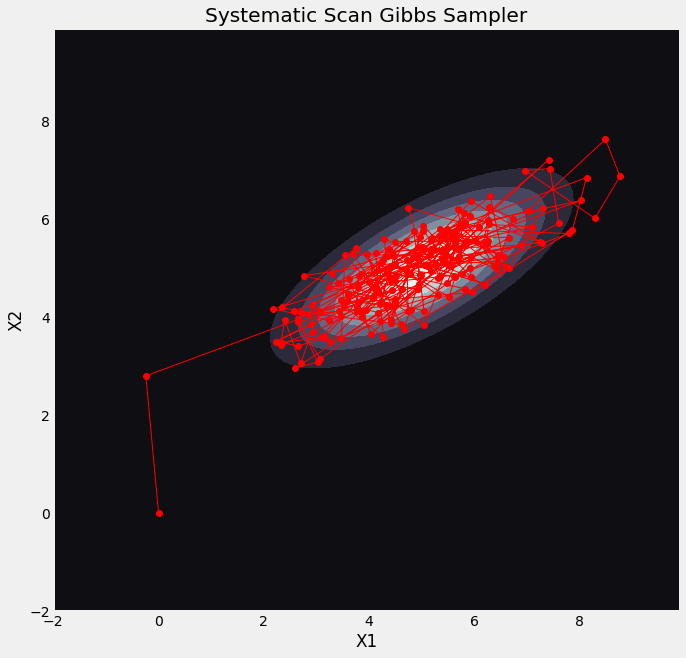

In [5]:
# Plot target distribution in white and grey
from matplotlib import style
style.use('fivethirtyeight')
from scipy.stats import multivariate_normal

sys_chain1 = sys_sampler.run(num_cycles=200)

x,y = np.mgrid[-2:10:.1, -2:10:0.1]

pos = np.dstack((x, y))
rv = multivariate_normal([mu1, mu2], [[var1, rho], [rho, var2]])
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)

# Separate the 1st and second dimensions of the states in the chain and
# plot the Gibbs sampler steps
sys_gibbs_x1 = np.asarray(sys_chain1)[:,0].tolist()
sys_gibbs_x2 = np.asarray(sys_chain1)[:,1].tolist()

plt.plot(sys_gibbs_x1, sys_gibbs_x2, marker='o', c='r', linewidth=1)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Systematic Scan Gibbs Sampler')
plt.show()

### Random Scan

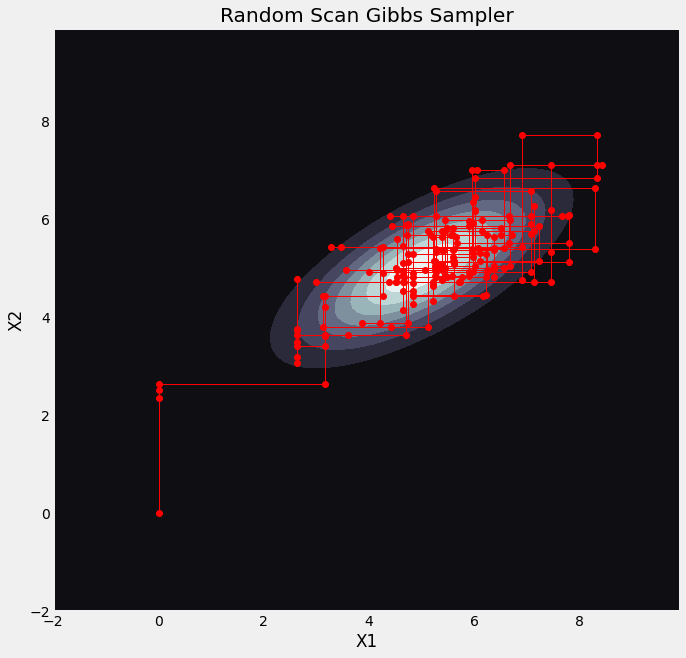

In [6]:
# Plot target distribution in white and grey

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)

rand_chain1 = rand_sampler.run(num_cycles=200)

# Separate the 1st and second dimensions of the states in the chain and
# plot the Gibbs sampler steps
rand_gibbs_x1 = np.asarray(rand_chain1)[:,0].tolist()
rand_gibbs_x2 = np.asarray(rand_chain1)[:,1].tolist()

plt.plot(rand_gibbs_x1, rand_gibbs_x2, marker='o', c='r', linewidth=1)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Random Scan Gibbs Sampler')
plt.show()

### Comparison

Text(0.5, 1.0, 'Random Scan')

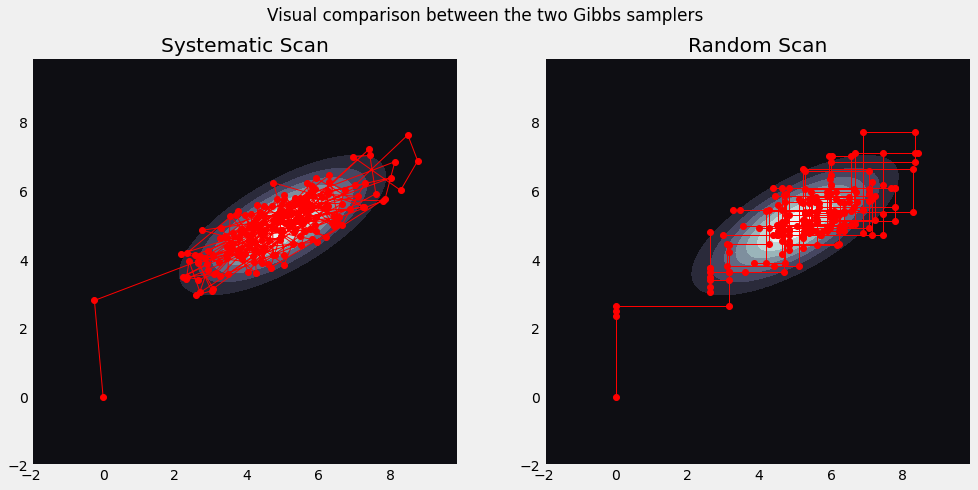

In [7]:
# Plot them side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Visual comparison between the two Gibbs samplers')

ax1.contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)
ax1.plot(sys_gibbs_x1, sys_gibbs_x2, marker='o', c='r', linewidth=1)
ax1.set_title('Systematic Scan')

ax2.contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)
ax2.plot(rand_gibbs_x1, rand_gibbs_x2, marker='o', c='r', linewidth=1)
ax2.set_title('Random Scan')

This show that the Systematic scan does a slightly better job at sampling from the target at the cost of slightly longer evaluation times